In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2 # Changed to ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input # ResNet50V2's specific preprocessor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix # Add this line

# 1. Mount Google Drive (essential for a new notebook or re-running in a fresh session)
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# 2. Define the ROOT directory for your VGG16-specific dataset on Google Drive
# We'll use the same naturally imbalanced dataset prepared previously.
VGG16_DATA_ROOT = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset')

# Verify that the dataset exists (optional, but good practice)
if not os.path.exists(VGG16_DATA_ROOT):
    print(f"Error: VGG16 dataset not found at {VGG16_DATA_ROOT}.")
    print("Please ensure the 'Phase 1: Data Preparation for VGG16' cell was run successfully.")
    # You might want to halt execution here or add re-creation logic if this is critical.

# 3. Define dataset paths for training, validation, and test splits
TRAIN_DIR = os.path.join(VGG16_DATA_ROOT, 'train')
VAL_DIR = os.path.join(VGG16_DATA_ROOT, 'val')
TEST_DIR = os.path.join(VGG16_DATA_ROOT, 'test')

# 4. Define your class names (must match the folder names in your dataset)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis",
    "Zalophus_wollebaeki"
]
NUM_CLASSES = len(CLASS_NAMES)
TARGET_IMG_SIZE = (224, 224) # ResNet50V2's common input size
BATCH_SIZE = 32

print(f"\nTraining ResNet-50V2 model for {NUM_CLASSES} classes: {CLASS_NAMES}")
print(f"Using dataset from: {VGG16_DATA_ROOT}")
print(f"Cropped images will be resized to: {TARGET_IMG_SIZE}")


# 5. Data Generators for training, validation, and testing
# IMPORTANT: Use preprocess_input specific to ResNet50V2
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For 2+ classes
    classes=CLASS_NAMES, # Ensure correct order
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False # No need to shuffle test data
)

print("\nData generators created.")
print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {val_generator.samples} validation images belonging to {val_generator.num_classes} classes.")
print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")


# 6. Build the ResNet-50V2 Model for Transfer Learning
# Load ResNet-50V2 pre-trained on ImageNet, without its top classification layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(TARGET_IMG_SIZE[0], TARGET_IMG_SIZE[1], 3))

# Freeze the convolutional base to train only the new layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# 7. Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 8. Define Callbacks for training
model_checkpoint_path_resnet = os.path.join( # Changed path for ResNet-50V2
    '/content/drive/My Drive',
    'vgg16_training_results', # Still using this parent folder
    'resnet50v2_classification_control_case', # New subfolder for ResNet-50V2
    'best_model.h5'
)
os.makedirs(os.path.dirname(model_checkpoint_path_resnet), exist_ok=True)

checkpoint = ModelCheckpoint(
    model_checkpoint_path_resnet,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=0.000001,
    mode='max',
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# 9. Train the Model
EPOCHS_RESNET = 50

print("\nStarting ResNet-50V2 model training (Control Case)...")
history_resnet = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_RESNET,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

print("\nResNet-50V2 Training (Control Case) complete!")
print(f"Best model saved to: {model_checkpoint_path_resnet}")

# Save training history
history_resnet_dict = history_resnet.history
history_filepath_resnet = os.path.join(os.path.dirname(model_checkpoint_path_resnet), 'training_history.json')
with open(history_filepath_resnet, 'w') as f:
    json.dump(history_resnet_dict, f)
print(f"Training history saved to: {history_filepath_resnet}")


# --- 10. Evaluate on test set and get more metrics ---
print("\nEvaluating model on the test set for detailed metrics...")

# Get true labels and predicted probabilities
Y_pred_proba_resnet = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + (test_generator.samples % BATCH_SIZE != 0))
Y_pred_classes_resnet = np.argmax(Y_pred_proba_resnet, axis=1)

# Get true class labels (indices)
Y_true_resnet = test_generator.classes[test_generator.index_array]

# Generate and Print Classification Report
print("\n--- ResNet-50V2 Classification Report (Control Case) ---")
report_resnet = classification_report(Y_true_resnet, Y_pred_classes_resnet, target_names=CLASS_NAMES)
print(report_resnet)

# Save Classification Report to Drive
report_filepath_resnet = os.path.join(os.path.dirname(model_checkpoint_path_resnet), 'classification_report.txt')
with open(report_filepath_resnet, 'w') as f:
    f.write(report_resnet)
print(f"Classification report saved to: {report_filepath_resnet}")

# Generate and Plot Confusion Matrix
print("\n--- ResNet-50V2 Confusion Matrix (Control Case) ---")
cm_resnet = confusion_matrix(Y_true_resnet, Y_pred_classes_resnet)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet-50V2 Confusion Matrix (Control Case)')
plt.show()

# Save Confusion Matrix plot to Drive
cm_filepath_resnet = os.path.join(os.path.dirname(model_checkpoint_path_resnet), 'confusion_matrix.png')
plt.savefig(cm_filepath_resnet)
print(f"Confusion matrix plot saved to: {cm_filepath_resnet}")

# Evaluate overall test set accuracy
test_loss_resnet, test_accuracy_resnet = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Loss: {test_loss_resnet:.4f}")
print(f"Test Accuracy: {test_accuracy_resnet:.4f}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!

Training ResNet-50V2 model for 2 classes: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']
Using dataset from: /content/drive/My Drive/vgg16_seals_classification_dataset
Cropped images will be resized to: (224, 224)
Found 379 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Found 54 images belonging to 2 classes.

Data generators created.
Found 379 training images belonging to 2 classes.
Found 64 validation images belonging to 2 classes.
Found 54 test images belonging to 2 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 49,255,682 (187.90 MB)

 Trainable params: 25,690,882 (98.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)


Starting ResNet-50V2 model training (Control Case)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7230 - loss: 4.6183
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_control_case/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 154s 14s/step - accuracy: 0.7331 - loss: 4.6496 - val_accuracy: 0.9375 - val_loss: 1.0816 - learning_rate: 1.0000e-04
Epoch 2/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.8438 - loss: 2.5789

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.93750
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8438 - loss: 2.5789 - val_accuracy: 0.9375 - val_loss: 0.7719 - learning_rate: 1.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8947 - loss: 0.3766
Epoch 3: val_accuracy improved from 0.93750 to 0.95312, saving model to /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_control_case/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.8946 - loss: 0.3692 - val_accuracy: 0.9531 - val_loss: 0.2077 - learning_rate: 1.0000e-04
Epoch 4/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.9375 - loss: 0.1641
Epoch 4: val_accuracy did not improve from 0.95312
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9375 - loss: 0.1641 - val_accuracy: 0.9531 - val_loss: 0.2275 - learning_rate: 1.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9629 - loss: 0.0987
Epoch 5: val_accuracy did not improve from 0.95312
11/11 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - accuracy: 0.9633 - loss: 0.0972 - val_accuracy: 0.9375 - val_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 6/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:08 7s/step - accuracy: 0.9375 - loss: 0.0904
Epoch 6: val_accuracy did not improve from 0.95312
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9375 - loss: 0.0904 - val_accuracy: 0.9375 - val_loss: 0.3287 - learning_rate: 1.0000e-04
Epoch 7/50
11/11 ━━━━━

NameError: name 'classification_report' is not defined

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Loading best model from: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_control_case/best_model.h5


Model loaded successfully.
Found 54 images belonging to 2 classes.

Found 54 test images belonging to 2 classes.

Evaluating model on the test set for detailed metrics...
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step

--- ResNet-50V2 Classification Report (Control Case) ---
                             precision    recall  f1-score   support

Arctocephalus_galapagoensis       1.00      0.20      0.33         5
        Zalophus_wollebaeki       0.92      1.00      0.96        49

                   accuracy                           0.93        54
                  macro avg       0.96      0.60      0.65        54
               weighted avg       0.93      0.93      0.90        54

Classification report saved to: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_control_case/classification_report.txt

--- ResNet-50V2 Confusion Matrix (Control Case) ---


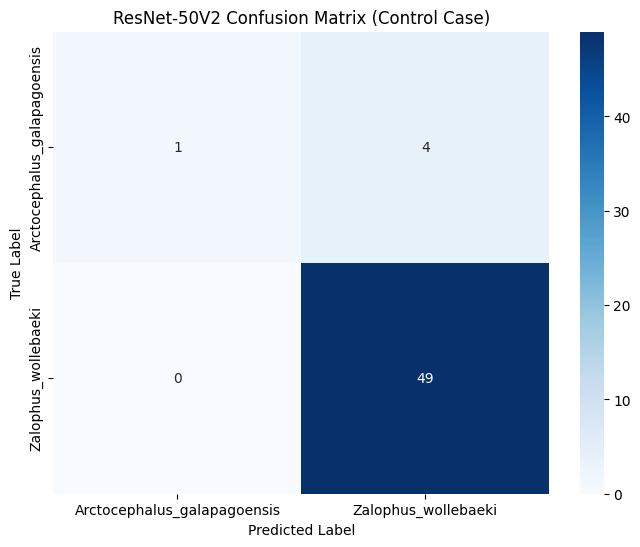

Confusion matrix plot saved to: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_control_case/confusion_matrix.png

Loading training history from: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_control_case/training_history.json


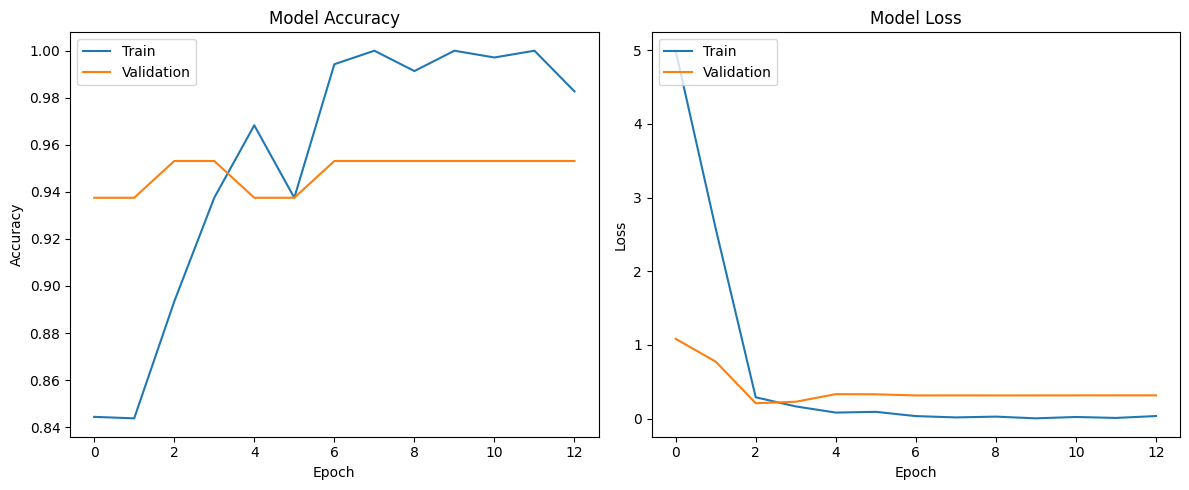

Training history plots saved to: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_control_case/training_history_plots.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8750 - loss: 0.3363

Overall Test Loss: 0.3363
Overall Test Accuracy: 0.8750


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model # Import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input # ResNet50V2's specific preprocessor
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json # To load history object if needed

# 1. Mount Google Drive (essential if in a new session)
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# 2. Define the ROOT directory for your VGG16-specific dataset on Google Drive
VGG16_DATA_ROOT = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset')

# Define test dataset path
TEST_DIR = os.path.join(VGG16_DATA_ROOT, 'test')

# Define class names (must match the folder names and order during training)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis",
    "Zalophus_wollebaeki"
]
NUM_CLASSES = len(CLASS_NAMES)
TARGET_IMG_SIZE = (224, 224) # ResNet50V2's common input size
BATCH_SIZE = 32

# Path to the saved best model (ResNet-50V2 Control Case)
MODEL_SAVE_DIR = os.path.join(
    '/content/drive/My Drive',
    'vgg16_training_results',
    'resnet50v2_classification_control_case' # The specific run folder
)
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_model.h5')
HISTORY_FILE_PATH = os.path.join(MODEL_SAVE_DIR, 'training_history.json') # Path to saved history

# --- 3. Load the Best Trained Model ---
if os.path.exists(BEST_MODEL_PATH):
    print(f"Loading best model from: {BEST_MODEL_PATH}")
    model = load_model(BEST_MODEL_PATH)
    print("Model loaded successfully.")
else:
    print(f"Error: Model not found at {BEST_MODEL_PATH}. Please ensure training completed successfully.")
    exit() # Exit if model not found

# --- 4. Prepare Test Data Generator ---
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # Same preprocessing as training
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False # IMPORTANT: Do NOT shuffle test data for consistent evaluation
)

print(f"\nFound {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")

# --- 5. Evaluate and Get Predictions ---
print("\nEvaluating model on the test set for detailed metrics...")

# Get true labels and predicted probabilities
# Using `steps` argument is important for completeness of prediction across all samples.
# `steps = test_generator.samples // BATCH_SIZE + (test_generator.samples % BATCH_SIZE != 0)` ensures all samples are covered.
Y_pred_proba = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + (test_generator.samples % BATCH_SIZE != 0))
Y_pred_classes = np.argmax(Y_pred_proba, axis=1) # Convert probabilities to class indices

# Get true class labels (indices)
# The order of labels from flow_from_directory is consistent with the test_generator.classes
Y_true = test_generator.classes[test_generator.index_array] # This extracts the true labels in the correct order

# --- 6. Generate and Print Classification Report ---
print("\n--- ResNet-50V2 Classification Report (Control Case) ---")
report = classification_report(Y_true, Y_pred_classes, target_names=CLASS_NAMES)
print(report)

# Save Classification Report to Drive
report_filepath = os.path.join(MODEL_SAVE_DIR, 'classification_report.txt')
with open(report_filepath, 'w') as f:
    f.write(report)
print(f"Classification report saved to: {report_filepath}")

# --- 7. Generate and Plot Confusion Matrix ---
print("\n--- ResNet-50V2 Confusion Matrix (Control Case) ---")
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet-50V2 Confusion Matrix (Control Case)')
plt.show()

# Save Confusion Matrix plot to Drive
cm_filepath = os.path.join(MODEL_SAVE_DIR, 'confusion_matrix.png')
plt.savefig(cm_filepath)
print(f"Confusion matrix plot saved to: {cm_filepath}")
plt.close() # Close plot to prevent it from showing multiple times if run in loop


# --- 8. Optional: Load and Plot Training History ---
if os.path.exists(HISTORY_FILE_PATH):
    print(f"\nLoading training history from: {HISTORY_FILE_PATH}")
    with open(HISTORY_FILE_PATH, 'r') as f:
        history_data = json.load(f)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_data['accuracy'])
    plt.plot(history_data['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_data['loss'])
    plt.plot(history_data['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

    # Save History Plots
    history_plot_filepath = os.path.join(MODEL_SAVE_DIR, 'training_history_plots.png')
    plt.savefig(history_plot_filepath)
    print(f"Training history plots saved to: {history_plot_filepath}")
    plt.close()
else:
    print(f"\nTraining history file not found at: {HISTORY_FILE_PATH}")

# Evaluate overall test set accuracy (redundant with classification report but good for quick check)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"\nOverall Test Loss: {test_loss:.4f}")
print(f"Overall Test Accuracy: {test_accuracy:.4f}")